<a href="https://colab.research.google.com/github/Montse1708/ProyectoFinal_Dashboard/blob/main/TI_1_ProyectoFinal_JessicaMorales_CarlaSanchez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Proyecto Final**

##Integrantes:
* **Nombre:** Jessica Montserrat Morales Enrique  
* **e-mail:** jessica.morales5556@alumnos.udg.mx

- **Nombre:** Carla Georgina Sánchez Arreguín
- **email:** carla.sanchez2472@alumnos.udg.mx

#MODULES

##Install modules

In [ ]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import math
import geopandas as gpd
import folium
import panel as pn
import panel.widgets as pnw
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

#DATASET

##Dataset de COVID en México

###Dataset almacenado en link

In [ ]:
#Cargar los datos del archivo CSV
#En el siguiente link se encuentra los datos almacenados
url = 'https://raw.githubusercontent.com/marianarf/covid19_mexico_analysis/master/mexico_covid19.csv'
df = pd.read_csv(url)

###Dataset descargado de Kaggle


In [ ]:
#Cargar el dataset con los datos
#Link del repositorio en Kaggle: https://www.kaggle.com/datasets/marianarfranklin/mexico-covid19-clinical-data?resource=download
df = pd.read_csv('/content/mexico_covid19.csv')

##GeoJSON de los límites de los estados de México

In [ ]:
# Descargar el archivo GeoJSON de los límites de México
geojson_url = 'https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json'
mexico_map = gpd.read_file(geojson_url)

#MOSTRAR MAPA

In [ ]:
# Quitar acentos
mexico_map['name'] = mexico_map['name'].apply(unidecode)

# Calcular el total de casos por estado(ENTIDAD)
total_casos_por_estado = df.groupby('ENTIDAD').size().reset_index(name='total_casos')

# Unir los datos de casos con el archivo GeoJSON
mexico_map = mexico_map.merge(total_casos_por_estado, left_on='name', right_on='ENTIDAD', how='left')

<ipython-input-11-9504c7b8b075>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_correlacion = df_filtrado.corr()


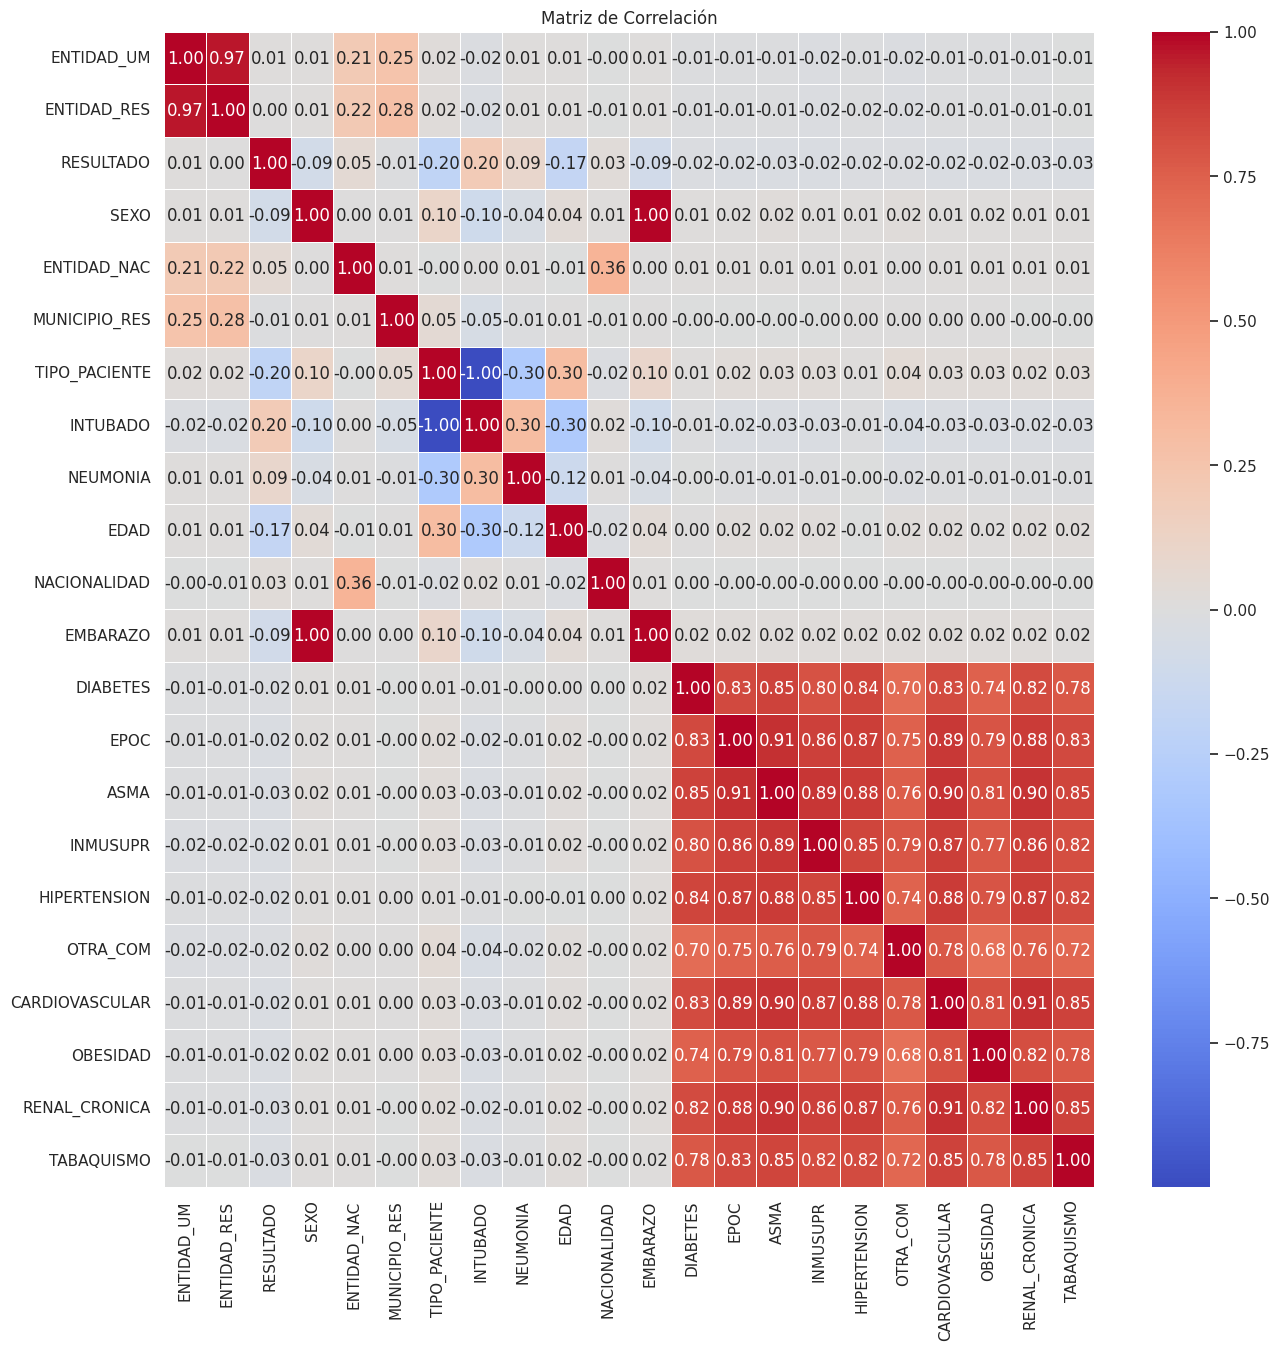

In [ ]:
columnas_seleccionadas = ["ENTIDAD_UM", "ENTIDAD_RES", "RESULTADO", "ENTIDAD", "SEXO", "ENTIDAD_NAC", "MUNICIPIO_RES",
                           "TIPO_PACIENTE", "INTUBADO", "NEUMONIA", "EDAD", "NACIONALIDAD", "EMBARAZO", "DIABETES",
                           "EPOC", "ASMA", "INMUSUPR", "HIPERTENSION", "OTRA_COM", "CARDIOVASCULAR", "OBESIDAD",
                           "RENAL_CRONICA", "TABAQUISMO"]

# Filtrar el DataFrame para incluir solo las columnas seleccionadas
df_filtrado = df[columnas_seleccionadas]

# Calcular la matriz de correlación
matriz_correlacion = df_filtrado.corr()

# Configurar el estilo de seaborn para mejorar la visualización
sns.set(style="white")

# Crear un mapa de calor con la matriz de correlación
plt.figure(figsize=(15, 15))
sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlación")
plt.show()